# Synopsis

![OpenBabel](http://openbabel.org/babel130.png)

In this kernel I will explore an alternative way of calculating local `mulliken charges`. 
You may be interrested only if you wish to incorportate these features in your model.  
=> The charges calculated with Open Babel are available as an autonomous dataset in [Open Babel Atom Charges](https://www.kaggle.com/asauve/open-babel-atom-charges)

The [Open Babel](http://openbabel.org/wiki/Main_Page) Package allow to
* Read .xyz files (the ones provided in the structures directory)
* Build bonding scheme (groovy baby!)
* Compute partial charges, with several builtin methods

Humm this last one is really interresting as it provides a quick way of computing atoms local charge with a method based on linear algebra. Hence it is fast and in the range of the allowed options for the competition.

The most promising method is Electronegativity Equalization Method  (EEM) which is describeed in this paper:  
[High-quality and universal empirical atomic charges for chemoinformatics applications](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4667495/)




# Changelog

* v5 : building of output dataset `ob_charges`
* v4 : first public version


# Load Data

In [1]:
import numpy as np # linear algebra
from scipy.stats.stats import pearsonr
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook as tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()
import os

Load CSV data

In [2]:
def load_dir_csv(directory, csv_files=None):
    if csv_files is None:
        csv_files = sorted( [ f for f in os.listdir(directory) if f.endswith(".csv") ])    
    csv_vars  = [ filename[:-4] for filename in csv_files ]
    gdict = globals()
    for filename, var in zip( csv_files, csv_vars ):
        print(f"{var:32s} = pd.read_csv({directory}/{filename})")
        gdict[var] = pd.read_csv( f"{directory}/{filename}" )
        print(f"{'nb of cols ':32s} = " + str(len(gdict[var])))
        display(gdict[var].head())

load_dir_csv("../input/", 
             ["train.csv", "structures.csv", "mulliken_charges.csv"])


train                            = pd.read_csv(../input//train.csv)
nb of cols                       = 4658147


id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                   84.8076  
1                  -11.2570  
2                  -11.2548  
3                  -11.2543  
4                   84.8074

structures                       = pd.read_csv(../input//structures.csv)
nb of cols                       = 2358657


molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397

mulliken_charges                 = pd.read_csv(../input//mulliken_charges.csv)
nb of cols                       = 1533537


molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0        -0.535689
1  dsgdb9nsd_000001           1         0.133921
2  dsgdb9nsd_000001           2         0.133922
3  dsgdb9nsd_000001           3         0.133923
4  dsgdb9nsd_000001           4         0.133923

# Install OpenBabel

The installation method was  demonstrated in: [Molecule with OpenBabel](https://www.kaggle.com/jmtest/molecule-with-openbabel)

In [10]:
#!conda install -y -c openbabel openbabel 
import openbabel as ob, openbabel
import pybel

In [ ]:
pybel.

In [36]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm_notebook

# Compare mullinken charges to Open Babel EEM


In [6]:
xyzmols={}
suppl = Chem.SDMolSupplier('../input/merged_mols.sdf',removeHs=False)
for mol in suppl:
    name=mol.GetProp("_Name").replace(".xyz","")
    xyzmols[name]=mol
len(xyzmols)

130774

In [11]:
obConversion = openbabel.OBConversion()
obConversion.SetInFormat("mol")

True

In [33]:
def read_ob_molecule(molname):
    mol2 = ob.OBMol()
    obConversion.ReadString(mol2, Chem.MolToMolBlock(xyzmols[molname]))
    return mol2

In [21]:
ob_charge_model = ob.OBChargeModel.FindType('eem')
ob_charge_model.ComputeCharges(mol2)
ob_charge_model.GetPartialCharges()

(-0.1029795284675401,
 -0.4642711758499283,
 0.09103208156362702,
 -0.15339955088034804,
 0.056973351882586995,
 -0.4751933410656092,
 0.2506413436719113,
 -0.15340024993144688,
 0.16575306696017267,
 0.16575748992547656,
 0.14088109127160048,
 0.16792635622246513,
 0.1423529609167502,
 0.16792610378028192)

In [37]:
    
ob_methods = [ "eem", "mmff94", "gasteiger", "qeq", "qtpie", 
               "eem2015ha", "eem2015hm", "eem2015hn", "eem2015ba", "eem2015bm", "eem2015bn" ]
mulliken   = []
ob_methods_charges = [ [] for _ in ob_methods]
mulliken_charges_idx = mulliken_charges.set_index(['molecule_name'])

ob_molecule_name = []  # container for output  DF
ob_atom_index    = []  # container for output  DF
for molecule_name in tqdm_notebook(train.molecule_name.unique()):
        if molecule_name in xyzmols:
            mc  = mulliken_charges_idx.loc[molecule_name].sort_index()
            mulliken.extend(mc.mulliken_charge.values)

            # fill data for output DF
            ob_molecule_name.extend( [molecule_name] * len(mc) )
            ob_atom_index.extend(    mc.atom_index.values )

            # calculate open babel charge for each method
            mol = read_ob_molecule(molecule_name)
            assert( mol.NumAtoms() == len(mc) )
            for method, charges in zip(ob_methods, ob_methods_charges):
                ob_charge_model = ob.OBChargeModel.FindType(method)
                ob_charge_model.ComputeCharges(mol)
                charges.extend( ob_charge_model.GetPartialCharges() )


method = eem         corr =  0.9318
method = mmff94      corr =  0.5802
method = gasteiger   corr =  0.6919
method = qeq         corr = -0.7894
method = qtpie       corr =  0.7562
method = eem2015ha   corr =  0.5997
method = eem2015hm   corr =  0.9076
method = eem2015hn   corr =  0.9264
method = eem2015ba   corr =  0.6473
method = eem2015bm   corr =  0.8562
method = eem2015bn   corr =  0.9377


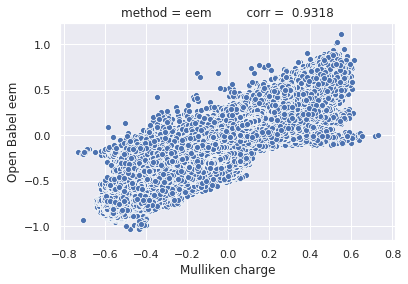

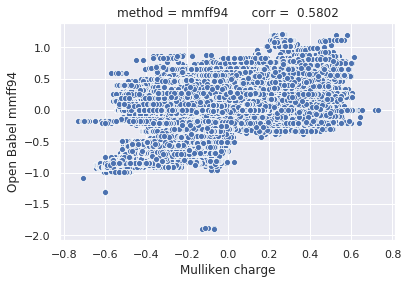

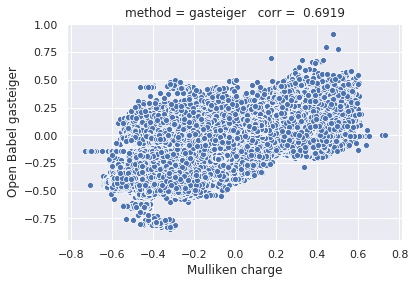

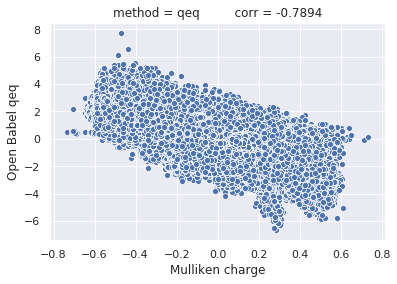

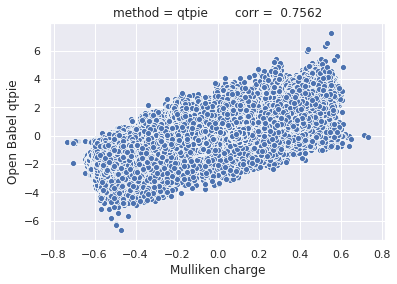

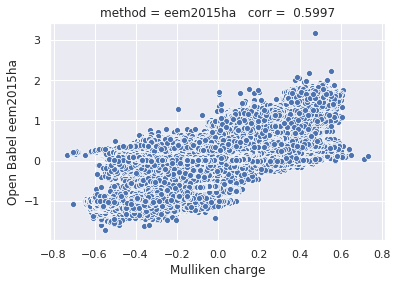

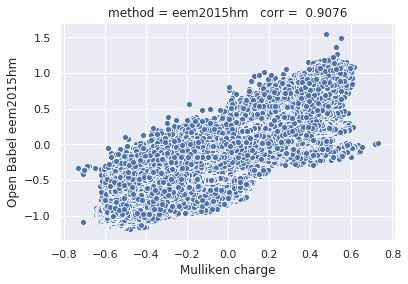

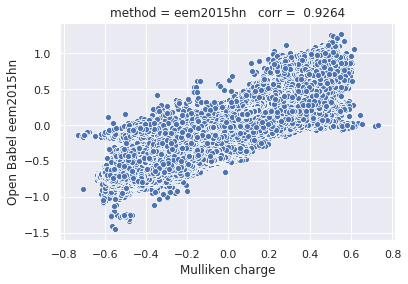

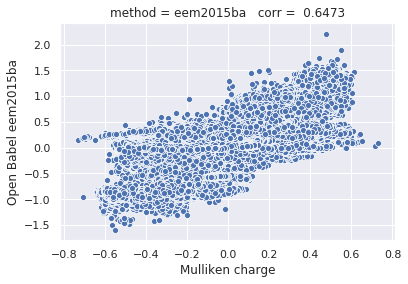

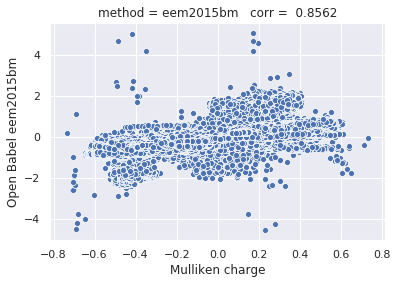

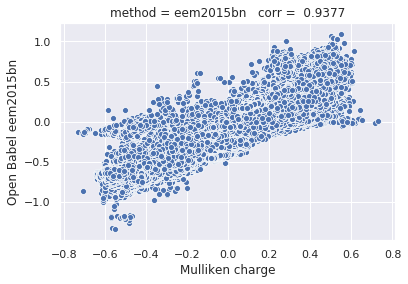

In [38]:
# correlation plots
corrs = []
for method, charges in zip(ob_methods, ob_methods_charges):
    fig = plt.figure()
    ax = sns.scatterplot(mulliken, charges)
    corr, pval = pearsonr(mulliken, charges)
    corrs.append(corr)
    title = f"method = {method:10s}  corr = {corr:7.4f}"
    print(title)
    plt.title(title)
    plt.xlabel("Mulliken charge")
    plt.ylabel(f"Open Babel {method}")


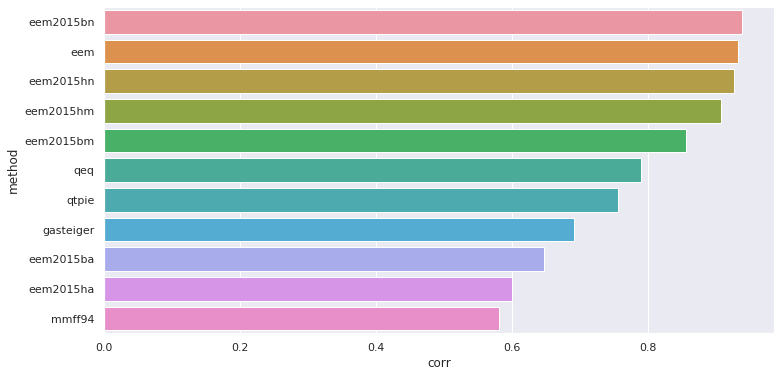

In [40]:
fig = plt.figure(figsize=(12,6))
data = pd.DataFrame( {'method':ob_methods, 'corr':[abs(c) for c in corrs]}).sort_values('corr', ascending=False)
ax = sns.barplot(data=data, x='corr', y='method', orient="h", dodge=False)

# Write Output dataframe `ob_charges`

In [3]:
import pandas as pd
ob_charges = pd.DataFrame({
    'molecule_name' : ob_molecule_name,
    'atom_index'    : ob_atom_index}
#    .update(tuple(zip(ob_methods, ob_methods_charges)))
    )
for method, charges in zip(ob_methods, ob_methods_charges):
    ob_charges[method] = charges
ob_charges.head()



NameError: name 'ob_molecule_name' is not defined

In [ ]:
ob_charges.to_csv("ob_charges.csv")

# Conclusion

Open Babel local charge estimation is worth a try in our models!

Best match is method **"eem"** and some of its variants!

Note that some outliers in the scatter plots come from different convention for how ionization charge is located inside the molecule. For example COO- can have -1 charge set on one O, or let it be shared by both oxygens. Hence the fact that some models differ from the data in the table `mulliken_charges` does not mean that it is systematically worse for the end purpose to predict coupling.
